In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import torch
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model

from hysteresis.base import BaseHysteresis
from hysteresis.hybrid import ExactHybridGP
from hysteresis.visualization import plot_hysterion_density

def ground_truth_function(m):
    return torch.sin(m)

def load():
    toy_model = torch.load('toy_magnet_decay.pt')

    train_h = toy_model.history_h.reshape(-1, 1).double()
    train_m = toy_model.history_m.reshape(-1, 1).double()

    train_y = ground_truth_function(train_m) + torch.randn(train_m.shape) * 0.0
    return train_h, train_m, train_y, toy_model

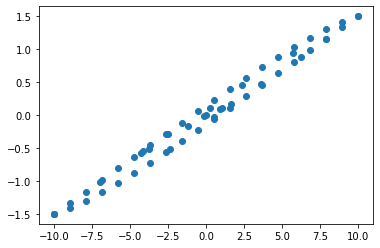

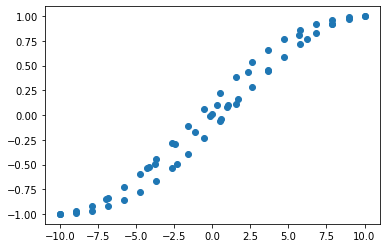

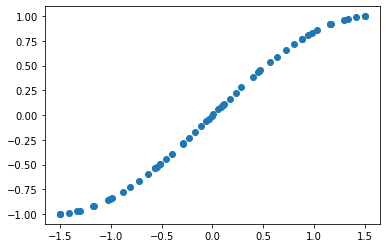

In [2]:
train_x, train_m, train_y, toy_model = load()
plt.figure()
plt.plot(train_x, train_m, 'o')

plt.figure()
plt.plot(train_x, train_y,'o')

plt.figure()
plt.plot(train_m, train_y,'o')

In [3]:
H = BaseHysteresis(
    train_x.flatten(),
    polynomial_degree=1,
    mesh_scale=0.5,
    trainable=True
)
model = ExactHybridGP(train_x, train_y.flatten().clone(), H)
mll = ExactMarginalLogLikelihood(model.gp.likelihood, model)

In [4]:
res = fit_gpytorch_model(mll, max_retries=10, options={'max_iter':20000})
for name, val in model.named_parameters():
    print(f'{name}:{val}')

hysteresis_models.0.raw_hysterion_density:Parameter containing:
tensor([-0.4448, -0.5581, -2.2834, -0.4504, -0.4485, -0.4432, -0.3521, -0.1020,
        -0.0125,  0.0456, -0.0635, -0.0075,  0.1322,  0.1857,  0.0856,  0.0401,
         0.2503,  0.1214, -1.0747, -2.0255, -2.4630, -1.0101,  0.2747, -1.1147,
        -1.0695, -0.6845, -0.6273, -0.9014, -0.7618, -0.5511, -2.0352, -1.9505,
        -1.3234, -1.8384, -1.5882, -0.2352, -0.6055, -0.6839, -0.3070, -0.2722,
        -0.4812, -0.6189, -0.3129,  0.2705,  0.4891,  0.3245, -0.6626, -0.8163,
        -0.6974, -0.7245, -0.5694, -0.4834, -0.8119, -1.0596, -0.7391, -0.4811,
        -0.6056, -0.5955, -0.5694, -0.5581, -0.5581, -0.1664, -0.0242,  0.6898,
         1.2751,  0.7681,  0.2413,  0.1795, -0.3685, -0.4264, -1.1957, -1.3855,
        -2.4167, -2.3217, -2.2045, -0.9005, -1.4725, -1.1851, -1.0257, -0.3075,
         0.1308,  0.7244,  0.5306,  0.6660,  0.5181,  0.6180,  0.2360, -0.1650,
        -0.2474, -0.4411, -0.4448, -1.1662,  0.3266, -1.

C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\botorch\fit.py:143: OptimizeWarning: Unknown solver options: max_iter
  warnings.warn(w.message, w.category)


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.collections.PolyCollection at 0x29d28e11340>)

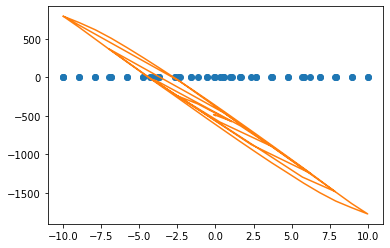

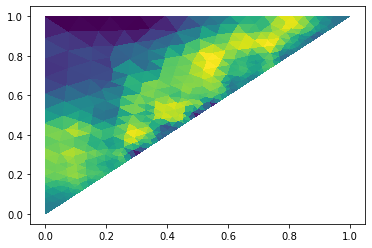

In [5]:
# prediction of hysteresis
model.hysteresis_models[0].regression()
plt.figure()
plt.plot(train_x, train_m, 'o')
plt.plot(
    train_x,
    model.hysteresis_models[0](train_x.flatten(), return_real=True).detach()
)

plot_hysterion_density(model.hysteresis_models[0])

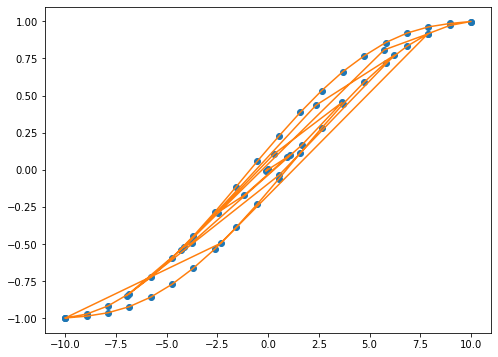

In [6]:
# compare fit to data
with torch.no_grad():
    post = model(train_x.double(), return_real=True)
    mean_out = post.mean
    #l, u = post.confidence_region()
plt.figure(figsize=(8,6))
plt.plot(train_x, train_y, 'o')
plt.plot(train_x, mean_out.detach())
#plt.fill_between(train_x.flatten(), l.flatten(), u.flatten(), alpha=0.25)

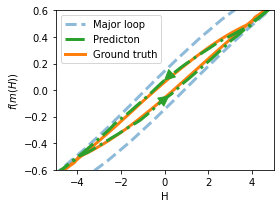

In [7]:
exp_model = deepcopy(toy_model)
# predict with joint model
flds = torch.tensor([-4, 4])
fig,axes = plt.subplots(1,1, sharex='all', sharey='all')
fig.set_size_inches(4,3)
lw = 3
handles = []
handles += [axes.plot(train_x[:40], train_y[:40],'--C0', lw=lw,label='Major loop',alpha=0.5)
[0]]
is_right = [1,0]
for idx, ele in enumerate(flds):
    exp_model.apply_field(ele)
    exp_model.next()

    model.apply_fields(ele.reshape(1,1))
    model.next()

    n = 100
    test_x = torch.linspace(*H.valid_domain, n)
    with torch.no_grad():
        post = model(test_x.double().reshape(-1, 1), return_real=True)
        mean = post.mean.flatten()
        std = torch.sqrt(post.variance).flatten()
        #l, u = post.confidence_region()

    m_gt = exp_model(test_x.double().reshape(-1,1))
    y_gt = ground_truth_function(m_gt).squeeze().detach()

    handles += [axes.plot(test_x, mean.detach(),'C2-.',lw=lw,label='Predicton')[0]]
    axes.fill_between(test_x, mean - std, mean + std, alpha=0.25)
    handles += [axes.plot(test_x, y_gt,'C1',lw=lw,label='Ground truth',zorder=0)[0]]
    axes.set_xlim(-5,5)
    axes.set_ylim(-0.6, 0.6)

    # add arrow to indicate direction
    start_idx = int(n/2)

    if is_right[idx]:
        end_idx = start_idx + 1
    else:
        end_idx = start_idx - 1

    axes.annotate(
        '',
        xytext=(test_x[start_idx], mean[start_idx].detach()),
        xy=(test_x[end_idx], mean[end_idx].detach()),
        arrowprops=dict(arrowstyle="-|>", color='C2'),
        size=25,
        zorder=0
    )

axes.set_ylabel('$f(m(H))$')
axes.set_xlabel('H')
fig.tight_layout()

axes.legend(handles=handles[:3])
fig.savefig('hybrid_toy_prediction.png', dpi=300)
